In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn import *
from scipy.interpolate import interp1d

# =================================
#             Functions
# =================================
def splitDate(arr):
    dateColumn = arr['Date'].str.split('-')
    arr['Year'] = pd.to_numeric(dateColumn.str[-3]);
    arr['Month'] = pd.to_numeric(dateColumn.str[-2]);
    arr['Week'] = pd.to_numeric(dateColumn.str[-1]) / 2;
    arr['DayFromBeginnig'] = pd.to_numeric(dateColumn.str[-2]) * 25 + pd.to_numeric(dateColumn.str[-1]);
    arr['combination2'] = arr['DayFromBeginnig'] / arr['Month'];
    arr['combination3'] = arr['Month'] / arr['Year'];
    arr['combination4'] = arr['DayFromBeginnig'] / arr['combination3'];
    return arr

def convertWeatherType(weather):
    weather['TS'] = pd.Series(0, index=weather.index)
    weather['FG'] = pd.Series(0, index=weather.index)
    i = 0
    for weatherElt in weather.values:
        if ('TS' in weatherElt[12]):
            weather.loc[i, 'TS'] = 1
        else:
            weather.loc[i, 'TS'] = 0
        
        if ('FG' in weatherElt[12]):
            weather.loc[i, 'FG'] = 1
        else:
            weather.loc[i, 'FG'] = 0
        i = i + 1
    return weather

def addTemperatureDiff(weather):
    weather['Tdiff_min'] = pd.Series(0, index=weather.index)
    weather['Tdiff_max'] = pd.Series(0, index=weather.index)
    weather['Tavg'].replace('M', np.nan, inplace = True);
    weather['Tavg'] = pd.to_numeric(weather['Tavg'])
    i = 0
    for weatherElt in weather.values:
        weather.loc[i, 'Tdiff'] = weatherElt[4] - weatherElt[3]
        i = i + 1
    return weather

def join_features_spray(data):
    data['SprayExist'] = pd.Series(0, index=train.index)
    i = 0
    for trainElt in data.values:
        curTrainMonth = datetime.datetime.strptime(trainElt[0], "%Y-%m-%d").month
        curTrainDay = datetime.datetime.strptime(trainElt[0], "%Y-%m-%d").day        
        if (curTrainMonth == 7 or curTrainMonth == 8 or curTrainMonth == 9) and curTrainDay > 10 and curTrainDay < 26:
            data.loc[i, 'SprayExist'] = 1
        i = i + 1
    return data

def speciesToNums(arr):
    arr.Species = arr.Species.map({'UNSPECIFIED CULEX': -1, 'CULEX ERRATICUS':0, 'CULEX SALINARIUS':1, 'CULEX TARSALIS':2, 'CULEX TERRITANS':3, 'CULEX RESTUANS':4, 'CULEX PIPIENS/RESTUANS':5, 'CULEX PIPIENS':6})
    return arr

# important: call begore deleting 'WnvPresent' from train
def makeTrapsOrder(arr):
    trapWnvPresent = arr.groupby('Trap')['WnvPresent'].mean()
    trapWnvPresent.sort_values(inplace=True)

    # smart ordinals
    i = 0
    while i < len(trapWnvPresent) and trapWnvPresent[i] == 0:
        trapWnvPresent[i] = 0
        i += 1
    start_num = i;
    while i < len(trapWnvPresent):
        trapWnvPresent[i] = i - start_num + 1;
        i += 1
    return trapWnvPresent;

def trapsToNums(trapsOrder, arr):
    def trap_process(x):
        if x in trapsOrder.index:
            return trapsOrder[x];
        else:
            return 0; # maybe not 0 when there is no information about trap (?)
    arr['Trap'] = arr['Trap'].map(lambda x: trap_process(x)) 
    return arr
    

def join_features_weather(train, weather):
    if (train.index.name != 'Date'):
        train = train.set_index('Date')
    joined = train.join(weather.set_index('Date'), rsuffix = 'r')
    return joined

def final_processing(arr, resCols):
    arr = arr.loc[:, resCols]
    arr.index.name = None
    arr.index = range(0, len(arr))
    # specific type transformations for some columns
    arr['Tavg_St1'] = pd.to_numeric(arr['Tavg_St1'])
    arr['Tavg_St2'] = pd.to_numeric(arr['Tavg_St2'])
    return arr

def our_cross_validation(train, trainAnswer, columnNames):
    # sort train for better cross_validation (date sorting)
    train = train.sort_index()
    
    # column types processing, deleting 'Data'
    train = final_processing(train, columnNames)
    
    # divide samples into two equal groups (according to the data)
    dataTrain = train.ix[0:len(train) / 2, ]
    dataTest = train.ix[len(train) / 2:len(train), ]
    resTrain = trainAnswer.ix[0:len(train) / 2, ]
    resTest = trainAnswer.ix[len(train) / 2:len(train), ]
    
    # training, training quality
    XGBoost = xgb.XGBClassifier(n_estimators=125)
    XGBoost.fit(dataTrain, resTrain)
    aucXGBTrain = metrics.roc_auc_score(resTrain, XGBoost.predict_proba(dataTrain)[:,1])
    print("train_cross_validated", aucXGBTrain)
    
    # test quality
    aucXGBTest = metrics.roc_auc_score(resTest, XGBoost.predict_proba(dataTest)[:,1])
    print("test_cross_validated", aucXGBTest)
    
    # plot feature importance
    fi = XGBoost.feature_importances_
    m = len(fi)
    ind = np.argsort(fi)
    cols = list(reversed(dataTrain.columns))
    fi = list(reversed(fi))

    from pylab import rcParams
    rcParams['figure.figsize'] = 12,7
    fig = plt.figure()
    plt.rc('font', family='Arial')
    plt.rcParams['xtick.labelsize'] = 20
    plt.bar(np.arange(len(cols)), fi, color='g')
    plt.xticks(np.arange(len(cols))+0.4, cols, rotation='vertical')
    fig.suptitle('Важность признаков', fontsize=20)
    
def get_answer_csv(train, trainAnswer, test, filePath, columnsName):
    
    train = final_processing(train, columnsName)
    test = final_processing(test, columnsName)
    
    # 0.0035 4060  
    # 0.0005 20060
    
    # training quality
    XGBoost = xgb.XGBClassifier(learning_rate=0.0035, n_estimators=4060, max_depth=3)
    XGBoost.fit(train, trainAnswer)
    aucXGBTrain = metrics.roc_auc_score(trainAnswer, XGBoost.predict_proba(train)[:,1])
    print("train_before_answer", aucXGBTrain)
    
    # test answers, file writing
    temp = pd.Series(XGBoost.predict_proba(test)[:,1])
    temp.index = range(1, len(temp) + 1)
    
    for i, line in enumerate(temp):
        if (test.loc[i, 'Species'] == 0):
            temp[i] = 0;
    temp.to_csv(filePath, header = True)


/Users/melaanya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/melaanya/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/melaanya/anaconda/lib/python3.5/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", Deprecation

In [2]:
# =================================
#             First settings
# =================================
namesArray = ['Date', 
              'Latitude', 
              'Longitude',
              'Trap', 
              'Month',
              'MsqCount',
              'Block', 
              'Week',
              'combination2',
              'combination3',
              'combination4',
              'Species', 
              'Year', 
              'AddressAccuracy',
              'DayFromBeginnig']

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# groups = train.groupby(['Trap', 'Species', 'Date']).agg({'Latitude': np.mean, 'Longitude': np.mean, 'NumMosquitos' : np.sum, 'WnvPresent': np.max,  'AddressAccuracy': np.min, 'Block': np.max})
# # groups = train.groupby(['Trap', 'Species', 'Date']).max()
# train = groups.reset_index()
# train.head()

In [4]:
# Smart trap encoding 
trapWnvPresent = makeTrapsOrder(train)
train = trapsToNums(trapWnvPresent, train)
test = trapsToNums(trapWnvPresent, test)

# Split date to year, month and week
train = splitDate(train)
test = splitDate(test)

groupped = train.groupby('Month').mean()
groupped.WnvPresent = groupped.WnvPresent * 1000

# Remove result column from train
trainAnswer = train['WnvPresent'];
train = train.drop('WnvPresent', axis = 1)

train['MsqCount'] = pd.Series(0, index=train.index)
test['MsqCount'] = pd.Series(0, index=test.index)

for item in groupped.index:
    train.loc[train['Month'] == item, 'MsqCount'] = groupped.loc[item,'WnvPresent']
    test.loc[test['Month'] == item, 'MsqCount'] = groupped.loc[item,'WnvPresent'] / 10
    
train.MsqCount = train.MsqCount**2
# test.MsqCount = test.MsqCount

train['DayFromBeginnig'] = train.DayFromBeginnig**2
test['DayFromBeginnig'] = test.DayFromBeginnig**2

train['Block'] = train.Block*2
# test['Block'] = test.Block*2

train['Trap'] = train.Trap*2
# test['Trap'] = test.Trap**2

train.Month = train.Month*2

# train.Year = train.Year / 2;

train.AddressAccuracy = train.AddressAccuracy*2
# test.AddressAccuracy = test.AddressAccuracy*2

# Convert species names to numbers
train = speciesToNums(train)
test = speciesToNums(test)

# ======== One-hot encoding example ========
# specie = pd.get_dummies(train.Species, prefix='Specie')
# train = train.join(specie)

# specieTest = pd.get_dummies(test.Species, prefix='Specie')
# test = test.join(specieTest)

# Get only columns from namesArray
train = train[namesArray]
test = test[namesArray]

train.head()

,Date,Latitude,Longitude,Trap,Month,MsqCount,Block,Week,Week2,Week3,Week4,Species,Year,AddressAccuracy,DayFromBeginnig
0,2007-05-29,41.954690,-87.800991,164.0,10,0.0,82,14.5,30.8,0.002491,61815.6,5,2007,18,23716
1,2007-05-29,41.954690,-87.800991,164.0,10,0.0,82,14.5,30.8,0.002491,61815.6,4,2007,18,23716
2,2007-05-29,41.994991,-87.769279,0.0,10,0.0,124,14.5,30.8,0.002491,61815.6,4,2007,18,23716
3,2007-05-29,41.974089,-87.824812,180.0,10,0.0,158,14.5,30.8,0.002491,61815.6,5,2007,16,23716
4,2007-05-29,41.974089,-87.824812,180.0,10,0.0,158,14.5,30.8,0.002491,61815.6,4,2007,16,23716


In [5]:
weather = pd.read_csv('weather.csv')
weather = convertWeatherType(weather)
weather = addTemperatureDiff(weather)
weather['Heat'].replace('M', np.nan, inplace = True);
weather['Heat'] = pd.to_numeric(weather['Heat'])
# weather.head()
weather['WetBulb'].replace('M', np.nan, inplace = True);
weather['WetBulb'] = pd.to_numeric(weather['WetBulb'])

In [6]:
# divide weather into two dataframes - station1 and station2
# join them to train on date

# do partition into 2 dataframes
weatherSt1 = weather.drop(weather[weather.Station == 2].index)
weatherSt1 = weatherSt1.add_suffix('_St1')

weatherSt2 = weather.drop(weather[weather.Station == 1].index)
weatherSt2 = weatherSt2.add_suffix('_St2')
weatherNamesArray_St1 = ['Tdiff_St1', 'Tavg_St1', 'Tmin_St1', 'DewPoint_St1']
weatherNamesArray_St2 = ['DewPoint_St2', 'Tavg_St2', 'Tmin_St2']

weatherSt1.rename(columns={'Date_St1':'Date'}, inplace=True)
weatherSt2.rename(columns={'Date_St2':'Date'}, inplace=True)

# Join train and test with weather
trainWeather = join_features_weather(train, weatherSt1);
trainWeather = join_features_weather(trainWeather, weatherSt2);

testWeather = join_features_weather(test, weatherSt1);
testWeather = join_features_weather(testWeather, weatherSt2);

trainWeather['Tavg_St1'] = trainWeather.Tavg_St1*2
testWeather['Tavg_St1'] = testWeather.Tavg_St1*2

# trainWeather['Tmin_St1'] = trainWeather.Tmin_St1*2
# testWeather['Tmin_St1'] = testWeather.Tmin_St1*2

# trainWeather['TrapByBlock'] = trainWeather['Trap'] * trainWeather['Block'];
# testWeather['TrapByBlock'] = testWeather['Trap'] * testWeather['Block'];

trainWeather['DayByTSt1'] = trainWeather['DayFromBeginnig'] / trainWeather['Tavg_St1'];
testWeather['DayByTSt1'] = testWeather['DayFromBeginnig'] / testWeather['Tavg_St1'];

trainWeather['DayByTSt1'] = trainWeather['DayByTSt1']**2;

trainWeather['AddressByBlock'] = trainWeather['AddressAccuracy'] / (trainWeather['Block'] + 1);
testWeather['AddressByBlock'] = testWeather['AddressAccuracy'] / (testWeather['Block'] + 1);

trainWeather['AddressByTrap'] = trainWeather['AddressAccuracy'] / (trainWeather['Trap'] + 1);
testWeather['AddressByTrap'] = testWeather['AddressAccuracy'] / (testWeather['Trap'] + 1);

trainWeather['BlockDiffAddress'] = trainWeather['Block'] - trainWeather['AddressAccuracy'];
testWeather['BlockDiffAddress'] = testWeather['Block'] - testWeather['AddressAccuracy'];

trainWeather['Tmin_St1ByMonth'] = trainWeather['Tmin_St1'] - trainWeather['Month'];
testWeather['Tmin_St1ByMonth'] = testWeather['Tmin_St1'] - testWeather['Month'];

trainWeather['combination4'] = trainWeather['combination4'] * 2;


# Create main array from names arrays and remove date
resArr_names = namesArray + weatherNamesArray_St1 + weatherNamesArray_St2;
resArr_names.remove('Date')
resArr_names.append('DayByTSt1')
resArr_names.append('AddressByTrap')
resArr_names.append('AddressByBlock')
resArr_names.append('BlockDiffAddress')
resArr_names.append('Tmin_St1ByMonth')
print(resArr_names)

['Latitude', 'Longitude', 'Trap', 'Month', 'MsqCount', 'Block', 'Week', 'Week2', 'Week3', 'Week4', 'Species', 'Year', 'AddressAccuracy', 'DayFromBeginnig', 'Tdiff_St1', 'Tavg_St1', 'Tmin_St1', 'DewPoint_St1', 'DewPoint_St2', 'Tavg_St2', 'Tmin_St2', 'DayByTSt1', 'AddressByTrap', 'AddressByBlock', 'BlockDiffAddress', 'Tmin_St1ByMonth']


In [7]:
# grouped = train.groupby(['Date', 'Latitude', 'Longitude']).count()
trainWeather[resArr_names].columns

Index(['Latitude', 'Longitude', 'Trap', 'Month', 'MsqCount', 'Block', 'Week',
       'Week2', 'Week3', 'Week4', 'Species', 'Year', 'AddressAccuracy',
       'DayFromBeginnig', 'Tdiff_St1', 'Tavg_St1', 'Tmin_St1', 'DewPoint_St1',
       'DewPoint_St2', 'Tavg_St2', 'Tmin_St2', 'DayByTSt1', 'AddressByTrap',
       'AddressByBlock', 'BlockDiffAddress', 'Tmin_St1ByMonth'],
      dtype='object')

train_cross_validated 0.92301675395
test_cross_validated 0.757488922099
train_before_answer 0.898378638538
finished computations


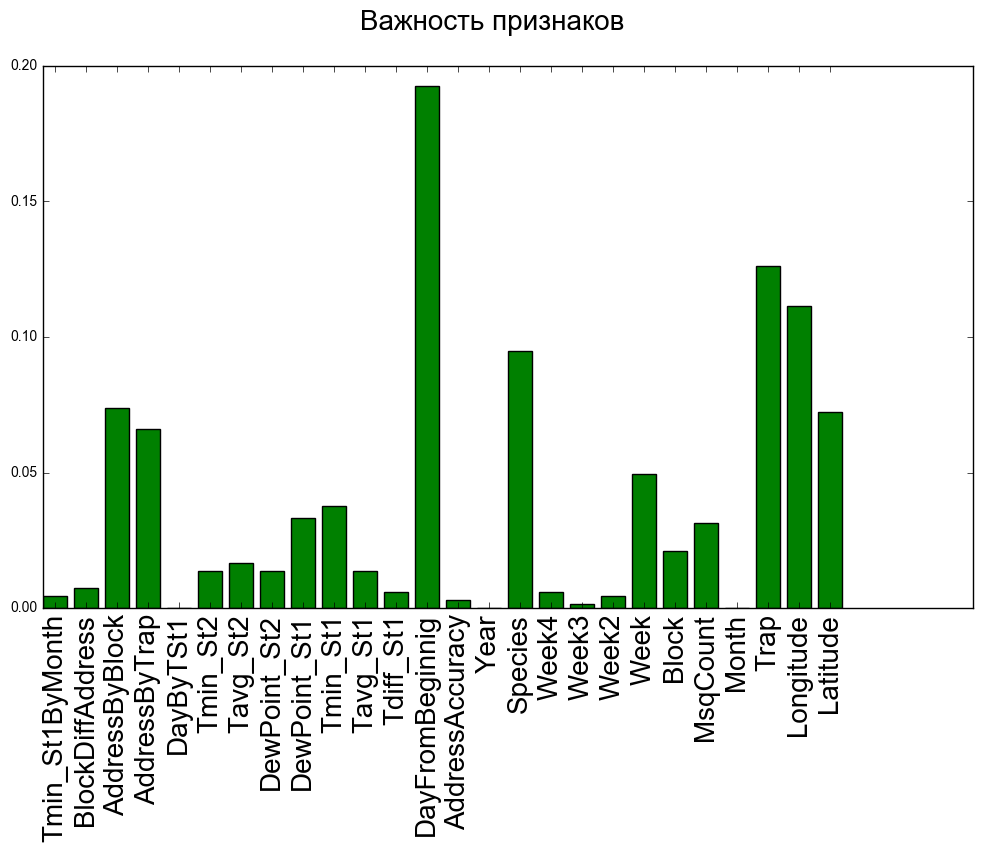

In [8]:
# Crossvalidation
our_cross_validation(trainWeather, trainAnswer, resArr_names)

# Get answer(print accuracy on train) and create csv
get_answer_csv(trainWeather, trainAnswer, testWeather, "submission-4-2611.csv", resArr_names)
print("finished computations")

In [9]:
# ======== Log of changes and results ========
# test =  0.765438164884 -- added DewPoint

# train_cross_validated 0.892873462633   
# test_cross_validated 0.763800723157 -- species ordered according to numMosquitos

# train_cross_validated 0.917247107727
# test_cross_validated 0.765633381843
# lg_before_answer 0.788143378415

In [10]:
# train = final_processing(trainWeather, resArr_names)

# predictors = [x for x in train.columns if x not in [target]]
# xgb1 = xgb.XGBClassifier(
#  learning_rate =0.1, 
#  n_estimators=100000, 
#  max_depth=5, 
#  min_child_weight=1, 
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)

# modelfit(xgb1, train, trainAnswer, predictors)
    

## 